In [1]:
!gdown '1-Ex3ssVpwPibjGzB9QTeMCcsRvZ9yceK'

Downloading...
From: https://drive.google.com/uc?id=1-Ex3ssVpwPibjGzB9QTeMCcsRvZ9yceK
To: /content/dataset.zip
100% 32.5M/32.5M [00:00<00:00, 264MB/s]


### 设置超参数

In [2]:
IMG_SIZE = 625
BATCH_SIZE = 2
EPOCHS = 1000
NUM_KEYPOINTS = 4 * 2  # 4 pairs each having x and y coordinates

### 准备数据集

In [3]:
!unzip -oq dataset.zip
!rm -rf ./dataset/.git
!rm -rf ./dataset/.DS_Store
!rm -rf __MACOSX
!rm -rf ./resized
!mkdir ./resized

### 加载数据集，将数据集转换成如下格式的字典。

```json
{
  "image_path1" => [627.6153846153846, 872.6410256410256, ...],
  "image_path2" => [...]
}
```

In [4]:
import os
import json
import pathlib
from PIL import Image
from matplotlib import pyplot as plt

json_dict = {}
for p in pathlib.Path('./dataset').glob('*'):
  plate = p.name  
  path = str(p)
  with open(f"{path}/{plate}.json") as file:
    os.mkdir(f"./resized/{plate}")

    resized_image_path = f"./resized/{plate}/{plate}.jpg"

    image = Image.open(f"{path}/{plate}.jpg")
    resized_image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    resized_image.save(resized_image_path)

    labels = []
    for p in json.load(file)['shapes'][0]['points']:
      labels.append(p[0] / image.width)
      labels.append(p[1] / image.height)

    json_dict[resized_image_path] = labels  

### 构建数据集

In [5]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

keys = list(json_dict.keys())
np.random.shuffle(keys)

train_keys, validation_keys = (keys[int(len(keys) * 0.1) :], keys[: int(len(keys) * 0.1)],)
train_labels = [json_dict[p] for p in train_keys]
validation_labels = [json_dict[p] for p in validation_keys]

def load_and_preprocess_image(plate, label):
  img = tf.io.read_file(plate)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [625, 625])
  img /= 255.0

  return img, label

train_dataset = (
  tf.data.Dataset.from_tensor_slices((train_keys, train_labels))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .batch(10)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = (
  tf.data.Dataset.from_tensor_slices((validation_keys, validation_labels))
    .map(load_and_preprocess_image, tf.data.experimental.AUTOTUNE)
    .cache()
    .batch(10)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
)

### 定义显示关键点方法

In [1]:
import numpy as np

def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(16, 12))
  [ax.axis("off") for ax in np.ravel(axes)]

  for ax_all, image, kp in zip(axes, images, keypoints):
    ax_all.imshow(image)
    for i in range(0, 4):
      ax_all.scatter([kp[i * 2] * IMG_SIZE], [kp[i * 2 + 1] * IMG_SIZE], c='red', marker="x", s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

### 检查一下数据

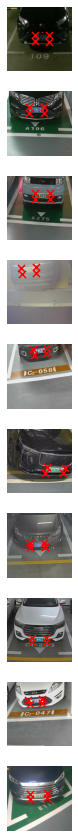

In [7]:
for image, points in train_dataset.take(1):
  sample_image, sample_points = image, points

visualize_keypoints(sample_image, sample_points)

### 构建模型

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(image_size):
    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    # Conv => Activation => Pool blocks.
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(inputs)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)     
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(33, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)    
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)
    x = layers.Conv2D(66, kernel_size=(3, 3), activation='relu')(x)   
    x = layers.MaxPool2D((2, 2))(x)                 
    # Linear layers.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=256, activation='relu')(x)
    x = layers.Dense(units=8)(x)
    model = tf.keras.Model(inputs, outputs=x)
    return model

### 生成模型

In [9]:
model = build_model((625, 625))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 625, 625, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 623, 623, 33)      924       
                                                                 
 conv2d_1 (Conv2D)           (None, 621, 621, 33)      9834      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 310, 310, 33)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 308, 308, 33)      9834      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 154, 154, 33)     0         
 2D)                                                         

### 预览模型架构

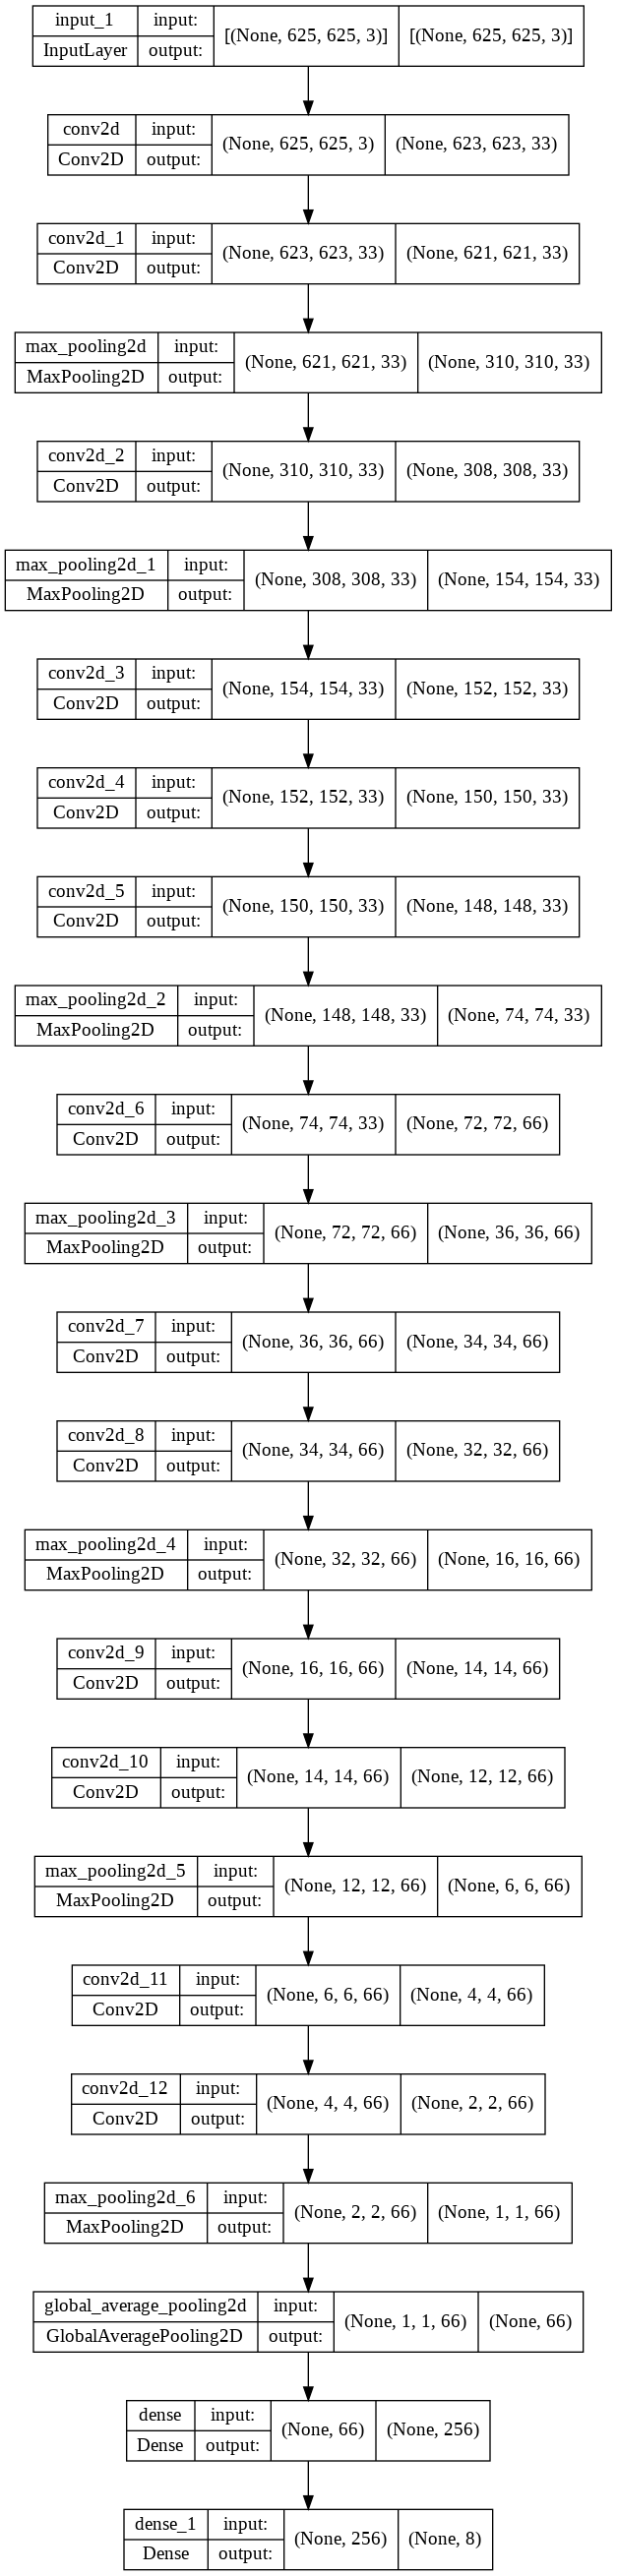

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 训练

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/1000
33/33 [==============================] - 46s 872ms/step - loss: 0.1531 - val_loss: 0.0475
Epoch 2/1000
33/33 [==============================] - 24s 715ms/step - loss: 0.0288 - val_loss: 0.0246
Epoch 3/1000
33/33 [==============================] - 24s 726ms/step - loss: 0.0244 - val_loss: 0.0209
Epoch 4/1000
33/33 [==============================] - 24s 720ms/step - loss: 0.0231 - val_loss: 0.0181
Epoch 5/1000
33/33 [==============================] - 24s 720ms/step - loss: 0.0216 - val_loss: 0.0176
Epoch 6/1000
33/33 [==============================] - 24s 722ms/step - loss: 0.0204 - val_loss: 0.0172
Epoch 7/1000
33/33 [==============================] - 24s 721ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 8/1000
33/33 [==============================] - 24s 726ms/step - loss: 0.0181 - val_loss: 0.0158
Epoch 9/1000
33/33 [==============================] - 24s 723ms/step - loss: 0.0167 - val_loss: 0.0131
Epoch 10/1000
33/33 [==============================] - 24s 722ms/step - l

### 显示训练结果

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:2]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 4, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 4, 2) * IMG_SIZE
 
print("实际")
visualize_keypoints(sample_val_images, sample_val_keypoints)

print("模型预测")
visualize_keypoints(sample_val_images, predictions)